# Dataset

In [1]:
model_type = 'convnet' # baseline, resnet, resnet_pretrained, convnet
restart_scheduler = 5
filter_sequences = False
only_test = False

In [2]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

In [3]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms
seq_len = 60

resize = None

mode = 'slide'
options = {
    'seq_len': seq_len,                            # = 500ms with ~ 5 calls
    'seq_skip': 15,
}

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         options, mode, resize, only_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:18<00:00,  1.03s/it]


In [4]:
import numpy as np
import pickle
        
if filter_sequences:
    with open('../call_nocall_seq.indices', 'rb') as file:
        indices, labels = pickle.load(file)
        
        train_indices = np.asarray(indices[0])
        test_indices = np.asarray(indices[1])
        val_indices = np.asarray(indices[2])
        
        train_call_seqs = []
        for i, seq in enumerate(train_indices):
            if len(seq) > 1:
                train_call_seqs.append(i)
        
        test_call_seqs = []
        for i, seq in enumerate(test_indices):
            if len(seq) > 1:
                test_call_seqs.append(i)
        
        val_call_seqs = []
        for i, seq in enumerate(val_indices):
            if len(seq) > 1:
                val_call_seqs.append(i)

        X_train = X_train[train_call_seqs]
        X_test = X_test[test_call_seqs]
        X_val = X_val[val_call_seqs]

        Y_train = Y_train[train_call_seqs]
        Y_test = Y_test[test_call_seqs]
        Y_val = Y_val[val_call_seqs]

In [5]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total sequences: 19190
(11323, 60, 44, 257) (11323,)


# Model
Sequence -> Feature map -> pos. encoding -> Transformer (CLS)

In [6]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor

sys.path.append('../addons/')
from sam import SAM
import einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torchsummary import summary
from torchmetrics.functional import f1_score

In [7]:
use_sampler = False
use_reduceonplateu = False
use_cosinescheduler = True
use_sam = True
use_mixup = False

In [8]:
from baseline import ResNet, Block

if model_type == 'baseline':
    baseline_model = ResNet(18, image_channels=1, num_classes=len(list(classes)))
    baseline_model.load_state_dict(torch.load('baseline.pth'))
    embedding_model = create_feature_extractor(baseline_model, return_nodes=["avgpool"])
    embedding_model.cuda()

    def extractFeatures(X):
        X_n = []
        for seq in tqdm.tqdm(X):
            tensor = torch.Tensor(seq).cuda()
            X_n.append(embedding_model(tensor.unsqueeze(dim=1))['avgpool'].squeeze(dim=1).squeeze(dim=-1).squeeze(dim=-1).cpu().detach().numpy())
        return np.asarray(X_n)

    X_train = extractFeatures(X_train)
    X_test = extractFeatures(X_test)
    X_val = extractFeatures(X_val)

In [9]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [10]:
class Net(nn.Module):
    """
    Classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        max_len,
        patch_dim,
        d_model,
        num_classes,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        classifier_dropout=0.1,
    ):

        super().__init__()

        assert d_model % nhead == 0, "nheads must divide evenly into d_model"
        
        if model_type == 'baseline':
            pass
        elif model_type == 'resnet':
            self.to_patch_embedding = ResNet(resnet_size, image_channels=1, num_classes=num_classes, include_last=False)
        elif model_type == 'resnet_pretrained':
            self.to_patch_embedding = ResNet(18, image_channels=1, num_classes=num_classes, include_last=False)
            self.to_patch_embedding.load_state_dict(torch.load('baseline.pth'), strict=False)
        elif model_type == 'convnet':
            self.to_patch_embedding = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=(5, 7), stride=(2, 3), padding=3),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

                nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

                nn.Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 2), padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
    
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len + 1, d_model))

        self.dropout = nn.Dropout(p=dropout)
        
        self.transformer_encoder = Transformer(
            dim=d_model,
            depth=num_layers,
            heads=nhead,
            dim_head=16,
            mlp_dim=dim_feedforward,
            dropout=dropout)
        
        self.classifier = nn.Sequential(nn.Flatten(1), nn.LayerNorm(60 * d_model), nn.Linear(60 * d_model, num_classes))
        
        self.d_model = d_model

    def forward(self, x):
        if model_type == 'baseline':
            pass
        elif model_type == 'resnet' or model_type == 'resnet_pretrained' or model_type == 'convnet':
            b, n, w, h = x.shape
            x = x.reshape((b * n, 1, w, h))
            x = self.to_patch_embedding(x)
            x = x.reshape((b, n, d_model))
        
        #cls = einops.repeat(self.cls_token, '1 n d -> b n d', b=x.shape[0])
        #x = torch.cat((cls, x), dim=1)
        #x += self.pos_encoder
        
        #x = self.dropout(x)
        #x = self.transformer_encoder(x)
        
        #x = x[:, 0]
        x = self.classifier(x)
        return x

In [11]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    running_f1 = 0.0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        if use_mixup:
            inputs, labels = mixup_fn(inputs, labels)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(inputs)

        # Compute Loss
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        if use_sam:
            optimizer.first_step()
            criterion(model(inputs), labels).backward()
            optimizer.second_step()
        else:
            optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        if use_mixup:
            predictions = torch.argmax(outputs, 1)
            running_corrects += (predictions == torch.argmax(labels, 1)).sum().item()
            running_f1 += f1_score(predictions, torch.argmax(labels, 1), num_classes=len(classes))
        else:
            predictions = torch.argmax(outputs, 1)
            running_corrects += (predictions == labels).sum().item()
            running_f1 += f1_score(predictions, labels, num_classes=len(classes))
    
        # Perform learning rate step
        if use_cosinescheduler:
            scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    epoch_f1 = running_f1 / num_batches
    
    return epoch_loss, epoch_acc, epoch_f1

In [12]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0  
        running_f1 = 0.0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            if use_mixup:
                inputs, labels = mixup_fn(inputs, labels)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            if use_mixup:
                predictions = torch.argmax(outputs, 1)
                running_corrects += (predictions == torch.argmax(labels, 1)).sum().item()
                running_f1 += f1_score(predictions, torch.argmax(labels, 1), num_classes=len(classes))
            else:
                predictions = torch.argmax(outputs, 1)
                running_corrects += (predictions == labels).sum().item()
                running_f1 += f1_score(predictions, labels, num_classes=len(classes))

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
        epoch_f1 = running_f1 / num_batches
    
    return epoch_loss, epoch_acc, epoch_f1

In [27]:
from torchsampler import ImbalancedDatasetSampler

max_len = seq_len
batch_size = 64
epochs = 25
lr = 0.01
warmup_epochs = 5
if model_type == "convnet":
    d_model = 64
else:
    d_model = 512
    

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3

if use_mixup:
    train_len = len(X_train) - len(X_train) % 2
    test_len = len(X_test) - len(X_test) % 2
    val_len = len(X_val) - len(X_val) % 2
    train_data = TensorDataset(torch.Tensor(X_train[:train_len]), torch.from_numpy(Y_train[:train_len]))
    test_data = TensorDataset(torch.Tensor(X_test[:test_len]), torch.from_numpy(Y_test[:test_len]))
    val_data = TensorDataset(torch.Tensor(X_val[:val_len]), torch.from_numpy(Y_val[:val_len]))
else:
    train_data = TensorDataset(torch.Tensor(X_train), torch.from_numpy(Y_train))
    test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
    val_data = TensorDataset(torch.Tensor(X_val), torch.from_numpy(Y_val))

if use_sampler:
    train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=ImbalancedDatasetSampler(test_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=ImbalancedDatasetSampler(val_data), batch_size=batch_size)
else:
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)

In [28]:
model = Net(
    max_len=max_len,
    patch_dim=resize[0]*resize[1] if resize is not None else patch_len * num_bands, # patch_len * num_bands, # 44 * 257 = 11,308
    d_model=d_model,
    num_classes=len(list(classes)),
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
    
model.to(device)
print(device)

cuda:0


In [29]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout,
    
    "use_sampler": use_sampler,
    "use_reduceonplateu": use_reduceonplateu,
    "use_cosinescheduler": use_cosinescheduler,
    "use_sam": use_sam,
    "use_mixup": use_mixup,
}

#wandb.init(project="BAT-2", entity="frankfundel", config=wandb_config)

criterion = nn.CrossEntropyLoss() # has softmax in it
if use_mixup:
    criterion = nn.BCEWithLogitsLoss()

if use_sam:
    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
scheduler = None
if use_cosinescheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)
if use_reduceonplateu:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [30]:
s_epoch = 0
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc, train_f1 = train_epoch(model, s_epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(train_loss, train_acc, train_f1), flush=True)
    
    val_loss, val_acc, val_f1 = test_epoch(model, s_epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(val_loss, val_acc, val_f1), flush=True)
    
    if use_reduceonplateu:
        scheduler.step(val_loss)
    
    '''wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    })'''
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(model.state_dict(), 'bat_2_' + model_type + '.pth')
    
    if s_epoch == restart_scheduler:
        s_epoch = 0
    else:
        s_epoch += 1

==================== Starting at epoch 0 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:58<00:00,  3.04it/s]

Training loss: 3.2034 Acc: 0.5182 F1: 0.5183



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.51it/s]

Validation loss: 6.8999 Acc: 0.4294 F1: 0.4283
val_loss decreased, saving model


==================== Starting at epoch 1 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:08<00:00,  2.59it/s]

Training loss: 2.1219 Acc: 0.6851 F1: 0.6852



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:16<00:00,  2.78it/s]

Validation loss: 2.6773 Acc: 0.6202 F1: 0.6131
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:25<00:00,  2.06it/s]

Training loss: 0.9990 Acc: 0.7978 F1: 0.7979



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  5.94it/s]

Validation loss: 1.8778 Acc: 0.6929 F1: 0.6916
val_loss decreased, saving model


==================== Starting at epoch 3 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:03<00:00,  2.79it/s]

Training loss: 0.3920 Acc: 0.8892 F1: 0.8892



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:09<00:00,  4.86it/s]

Validation loss: 1.2700 Acc: 0.7323 F1: 0.7255
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:08<00:00,  2.57it/s]

Training loss: 0.1662 Acc: 0.9422 F1: 0.9422



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:10<00:00,  4.47it/s]

Validation loss: 1.1767 Acc: 0.7455 F1: 0.7408
val_loss decreased, saving model
==================== Starting at epoch 5 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:07<00:00,  2.62it/s]

Training loss: 0.7842 Acc: 0.8352 F1: 0.8352



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  8.20it/s]

Validation loss: 3.4839 Acc: 0.6021 F1: 0.5978
==================== Starting at epoch 6 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:04<00:00,  2.76it/s]

Training loss: 0.8139 Acc: 0.8400 F1: 0.8400



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  5.77it/s]


Validation loss: 3.5093 Acc: 0.6056 F1: 0.6012
==================== Starting at epoch 7 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:04<00:00,  2.74it/s]

Training loss: 0.5328 Acc: 0.8819 F1: 0.8819



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.37it/s]

Validation loss: 2.3549 Acc: 0.6984 F1: 0.6970
==================== Starting at epoch 8 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:02<00:00,  2.82it/s]

Training loss: 0.1702 Acc: 0.9514 F1: 0.9514



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.73it/s]

Validation loss: 1.8027 Acc: 0.7483 F1: 0.7435
==================== Starting at epoch 9 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:02<00:00,  2.81it/s]

Training loss: 0.0389 Acc: 0.9855 F1: 0.9855



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00,  9.30it/s]

Validation loss: 1.6748 Acc: 0.7538 F1: 0.7466
==================== Starting at epoch 10 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:01<00:00,  2.87it/s]

Training loss: 0.0091 Acc: 0.9980 F1: 0.9980



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.51it/s]

Validation loss: 1.6334 Acc: 0.7555 F1: 0.7483
==================== Starting at epoch 11 ====================



  4%|██████                                                                                                                                                  | 7/177 [00:02<01:06,  2.54it/s]


KeyboardInterrupt: 

In [31]:
model.load_state_dict(torch.load('bat_2_' + model_type + '.pth'))
#compiled_model = torch.jit.script(model)
#torch.jit.save(compiled_model, 'bat_1.pt')

<All keys matched successfully>

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    output = model(inputs.cuda()) # Feed Network

    output = torch.argmax(output, 1).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    #labels = torch.argmax(labels, 1).data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:28<00:00,  2.77it/s]


In [33]:
wrongs = np.equal(Y_pred, Y_true)
wrongly_classified_seqs = X_test[np.invert(wrongs)]
wrongly_classified_pred = np.asarray(Y_pred)[np.invert(wrongs)]
wrongly_classified_true = np.asarray(Y_true)[np.invert(wrongs)]

In [34]:
print(np.asarray(wrongly_classified_seqs).shape, np.asarray(Y_pred).shape)

(1257, 60, 44, 257) (4979,)


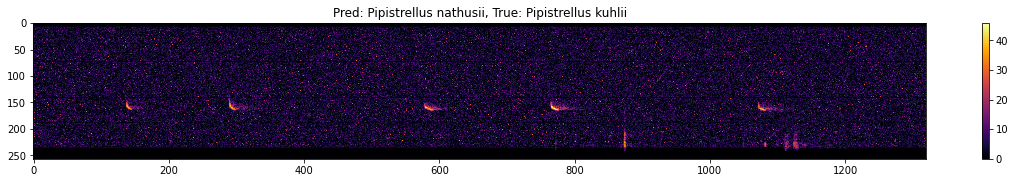

In [35]:
def stitch(a, r):
    return a[::r]
  
def plot_sequence(seq, p, t):
    plt.figure(figsize = (20, 2.5))
    stitched = stitch(seq, int(patch_len / patch_skip))
    spec = np.rot90(np.concatenate(stitched))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    plt.title("Pred: " + list(classes)[p] + ", True: " + list(classes)[t])
    
k = 112
plot_sequence(wrongly_classified_seqs[k], wrongly_classified_pred[k], wrongly_classified_true[k])

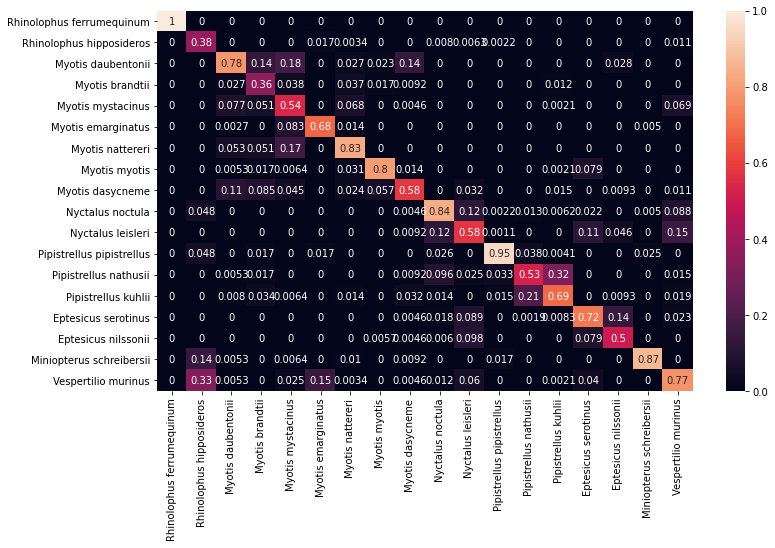

In [36]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('bat_2_' + model_type + '_cf.png')

In [37]:
import sklearn
corrects = np.equal(Y_pred, Y_true).sum()
test_acc = corrects/len(Y_pred)
f1 = sklearn.metrics.f1_score(Y_true, Y_pred, average=None).mean()
print("Test accuracy:", test_acc)
print("F1-score:", f1)

Test accuracy: 0.7475396665997188
F1-score: 0.6969186370416142


In [38]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

145490


In [ ]:
wandb.log({
    "test_acc": test_acc,
    "f1_score": f1,
    "num_params": pytorch_total_params,
})

In [ ]:
wandb.finish()